<a href="https://www.kaggle.com/code/orestasdulinskas/network-intrusion-detection?scriptVersionId=187687575" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

![Network Intrusion](https://media.defense.gov/2019/Sep/24/2002186571/-1/-1/0/190626-D-NU123-001.JPG)

# Network Intrusion Detection
---
## Background
In today's interconnected digital world, network security is a paramount concern for organizations and individuals alike. With the increasing sophistication and frequency of cyber attacks, traditional intrusion detection systems often struggle to keep up. This has led to a growing interest in leveraging advanced machine learning techniques to enhance the detection and prevention of malicious network activities. One promising approach is the use of artificial neural networks (ANNs) to analyze network flow data and identify potential intrusions. This project aims to utilize the LUFlow dataset, a comprehensive and continuously updated repository of network telemetry, to develop a neural network model capable of detecting malicious network intrusions effectively.

## Objective
The primary objective of this project is to develop and train an artificial neural network (ANN) model to detect malicious network intrusions using the LUFlow dataset. The specific goals include:
1. Creating a robust ANN model that can accurately distinguish between benign, malicious and outlier network traffic.
2. Enhancing the overall effectiveness and responsiveness of network intrusion detection systems by integrating advanced machine learning techniques.

## Data
The LUFlow dataset is a flow-based network intrusion detection dataset that provides a rich ground truth for malicious behavior through the correlation of telemetry data with third-party Cyber Threat Intelligence (CTI) sources. This dataset includes various types of network traffic, captured from Lancaster University's address space, and is designed to promote research into detection mechanisms for emerging threats.

Key features of the LUFlow dataset include:
- **Comprehensive Coverage:** The dataset contains telemetry data from both normal and malicious network activities, including traffic from production services such as SSH and database traffic.
- **Robust Ground Truth:** The labelling mechanism is autonomous and supported by a robust ground truth, enabling constant capture, labelling, and publishing of telemetry data.
- **Outlier Detection:** Flows that cannot be determined as malicious but do not conform to normal traffic profiles are labeled as outliers, encouraging further analysis to understand their intent.
- **Continuous Updates:** The dataset is continuously updated to reflect novel and emerging attack patterns, ensuring that the detection mechanisms developed using this data remain relevant and effective.

For this project, the dataset from September 2020 will be used, comprising over 26 million rows and 15 columns, with a total memory size of over 3.3GB. This extensive dataset provides a rich source of information for training the ANN model, enabling it to learn the subtle distinctions between normal and malicious network traffic and to adapt to evolving threats.

# Data Cleaning
---

In [1]:
import pandas as pd
import glob
import warnings
warnings.filterwarnings("ignore")

input_directory = '/kaggle/input/luflow-network-intrusion-detection-data-set'
all_filenames = [f for f in glob.glob(f'{input_directory}/2020/09/**/*.csv', recursive=True)]

df = pd.concat([pd.read_csv(f) for f in all_filenames])
chunk_size = 10000

df.head()

,avg_ipt,bytes_in,bytes_out,dest_ip,dest_port,entropy,num_pkts_out,num_pkts_in,proto,src_ip,src_port,time_end,time_start,total_entropy,label,duration
0,68.00,270,191,786,445.0,4.560631,6,6,6,25159,60329.0,1600942600256727,1600942599741146,2102.45100,outlier,0.515581
1,74.00,270,191,786,445.0,4.560631,5,6,6,25159,31214.0,1600942599063482,1600942598532111,2102.45100,outlier,0.531371
2,73.75,270,191,786,445.0,4.560631,6,6,6,25159,9472.0,1600942599861993,1600942599331834,2102.45100,outlier,0.530159
3,5.50,48,48,61337,123.0,4.720246,1,1,17,786,123.0,1600942600696141,1600942600684383,453.14365,malicious,0.011758
4,72.25,270,191,786,445.0,4.560631,6,6,6,25159,52716.0,1600942597868356,1600942597337825,2102.45100,outlier,0.530531


In [2]:
df.info() # Summary of DataFrame information

print('\nNumber of unique values in each column')
for i in df.columns:
    print(f'{i} - {df[i].nunique()}')
    
print('\nNumber of duplicated rows\n', df.duplicated().sum())

print('\nNumber of missing values in each column\n', df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
Index: 26206532 entries, 0 to 564537
Data columns (total 16 columns):
 #   Column         Dtype  
---  ------         -----  
 0   avg_ipt        float64
 1   bytes_in       int64  
 2   bytes_out      int64  
 3   dest_ip        int64  
 4   dest_port      float64
 5   entropy        float64
 6   num_pkts_out   int64  
 7   num_pkts_in    int64  
 8   proto          int64  
 9   src_ip         int64  
 10  src_port       float64
 11  time_end       int64  
 12  time_start     int64  
 13  total_entropy  float64
 14  label          object 
 15  duration       float64
dtypes: float64(6), int64(9), object(1)
memory usage: 3.3+ GB

Number of unique values in each column
avg_ipt - 362122
bytes_in - 50405
bytes_out - 65531
dest_ip - 2074
dest_port - 65525
entropy - 3939379
num_pkts_out - 256
num_pkts_in - 256
proto - 7
src_ip - 4207
src_port - 65533
time_end - 26020662
time_start - 25999997
total_entropy - 8012298
label - 3
duration - 2887345

Number of

In [3]:
df.dropna(inplace=True)

In [4]:
df.drop_duplicates(inplace=True)

# Feature Selection
---

### Feature Engineering

In [5]:
def feature_engineering(data):
    data['pkt_rate'] = data['num_pkts_in'] - data['duration']
    data['total_bytes'] = data['bytes_in'] + data['bytes_out']
    data['total_pkts'] = data['num_pkts_in'] + data['num_pkts_out']
    return data

In [6]:
df = feature_engineering(df)

### Using 10% sample of full data

In [7]:
sample_df = df.sample(frac=0.1, random_state=42)

### Finding feature correlations to each target label

In [8]:
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

fig = make_subplots(rows=3, cols=1, shared_xaxes=True)

fig.append_trace(go.Bar(name = 'Benign', 
    x=sample_df.join(pd.get_dummies(sample_df['label'], prefix='label')).drop(['label', 'label_malicious', 'label_outlier'], axis=1).corr()['label_benign'][:-1].index,
    y=sample_df.join(pd.get_dummies(sample_df['label'], prefix='label')).drop(['label', 'label_malicious', 'label_outlier'], axis=1).corr()['label_benign'][:-1].values),row=1, col=1)

fig.append_trace(go.Bar(name = 'Malicious',
    x=sample_df.join(pd.get_dummies(sample_df['label'], prefix='label')).drop(['label', 'label_benign', 'label_outlier'], axis=1).corr()['label_malicious'][:-1].index,
    y=sample_df.join(pd.get_dummies(sample_df['label'], prefix='label')).drop(['label', 'label_benign', 'label_outlier'], axis=1).corr()['label_malicious'][:-1].values), row=2, col=1)

fig.append_trace(go.Bar(name = 'Outlier',
    x=sample_df.join(pd.get_dummies(sample_df['label'], prefix='label')).drop(['label', 'label_malicious', 'label_benign'], axis=1).corr()['label_outlier'][:-1].index,
    y=sample_df.join(pd.get_dummies(sample_df['label'], prefix='label')).drop(['label', 'label_malicious', 'label_benign'], axis=1).corr()['label_outlier'][:-1].values), row=3, col=1)

fig.update_layout(title_text="Correlations by label", template='ggplot2')
fig.show()

### Getting Feature Importances

In [9]:
from sklearn.ensemble import RandomForestClassifier

# Train the model
model = RandomForestClassifier()
model.fit(sample_df.drop('label', axis=1), sample_df['label'])

# Get feature importances
importances = model.feature_importances_

# Convert the importances into a DataFrame
feature_importance_df = pd.DataFrame({
    'Feature': sample_df.drop('label', axis=1).columns,
    'Importance': importances
})

# Sort the DataFrame to plot
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

px.bar(feature_importance_df, x='Feature', y='Importance', template='ggplot2', title='Feature Importances')

In [10]:
numerical = ['src_ip','dest_port', 'src_port', 'total_entropy', 'bytes_out'] # Most important features

# Exploratory Data Analysis
---

### Target label distribution

In [11]:
import plotly.express as px

subject = sample_df['label'].value_counts().reset_index(name='count')
subject['percentage'] = (subject['count'] / subject['count'].sum()) * 100
fig = px.bar(subject, x='label', y='count', text='percentage', title='Defects by Priority', template='ggplot2')
fig.update_traces(texttemplate='%{text:.0f}%')
fig.show()

### Univariate Analysis

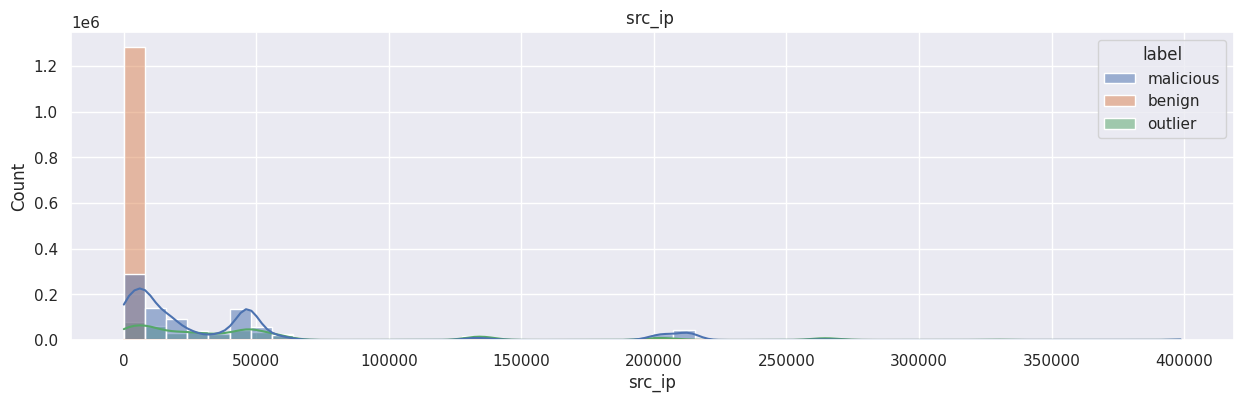

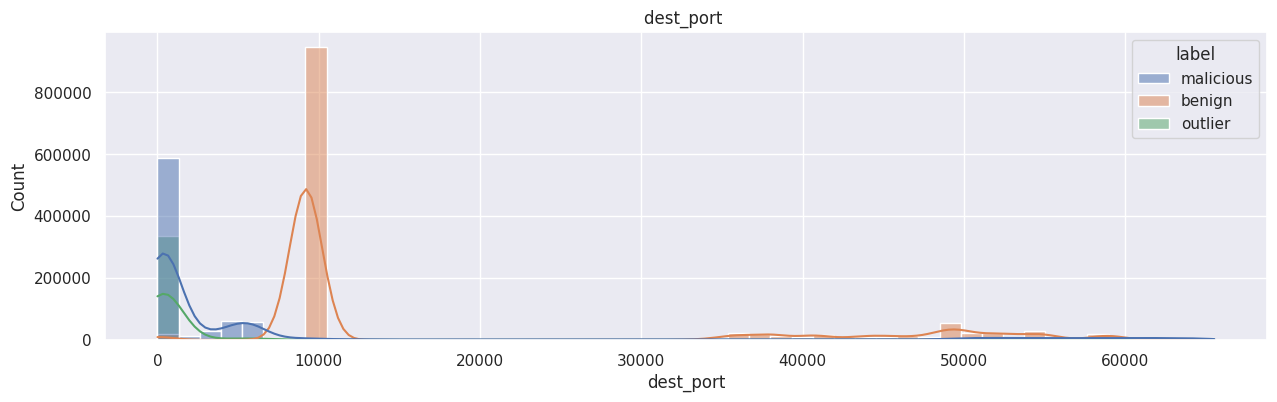

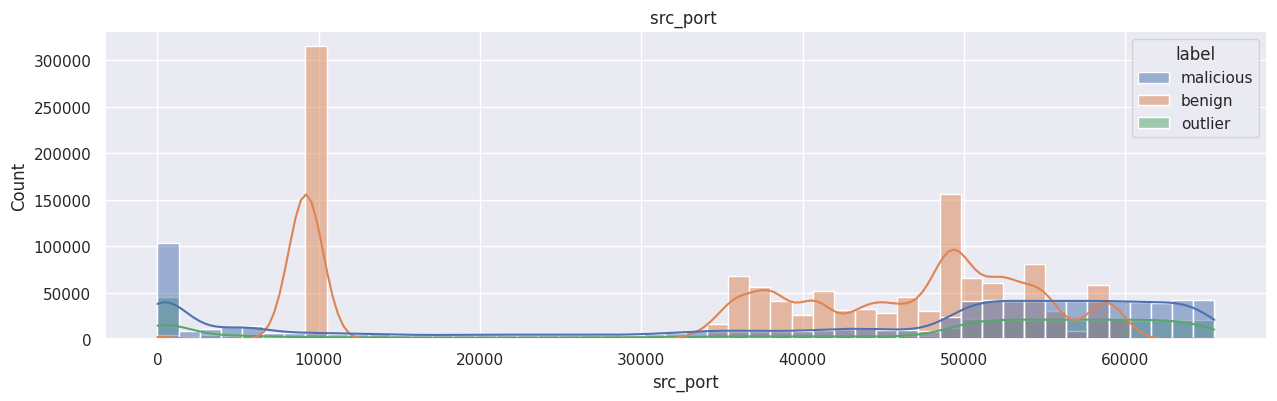

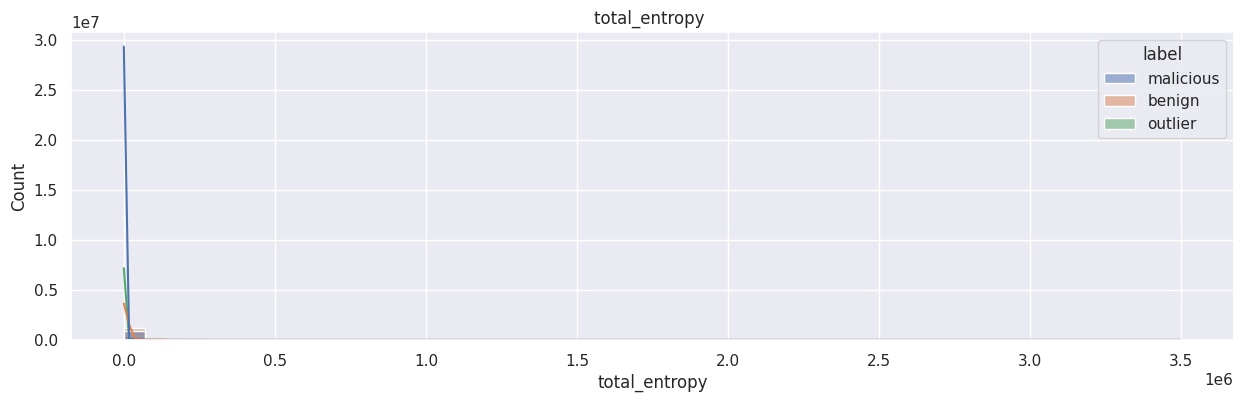

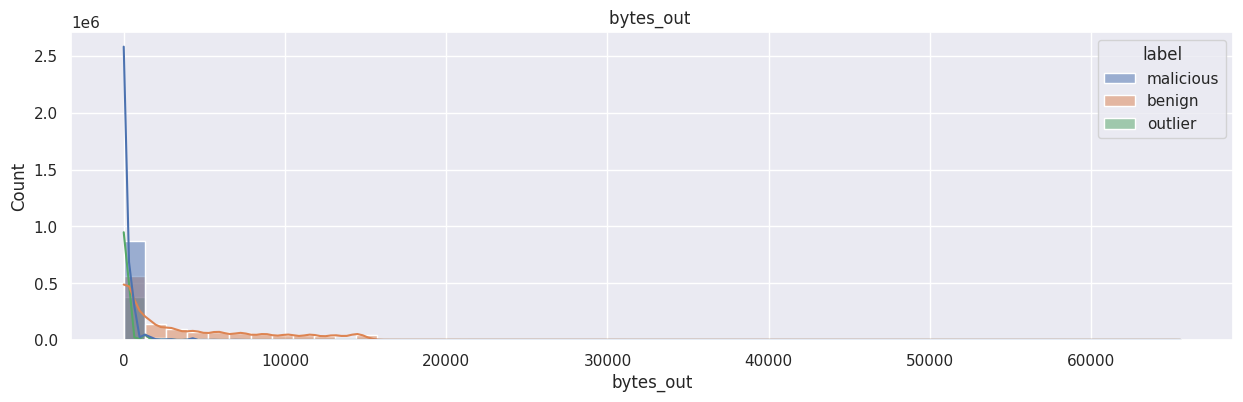

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

for i in numerical:
    fig, ax = plt.subplots(figsize=(15, 4))
    fig = sns.histplot(data=sample_df, x=i, hue="label", bins=50, kde=True)
    fig.set_title(f'{i} ')
    fig.grid(True)
    plt.show()

### Bi-variate Analysis

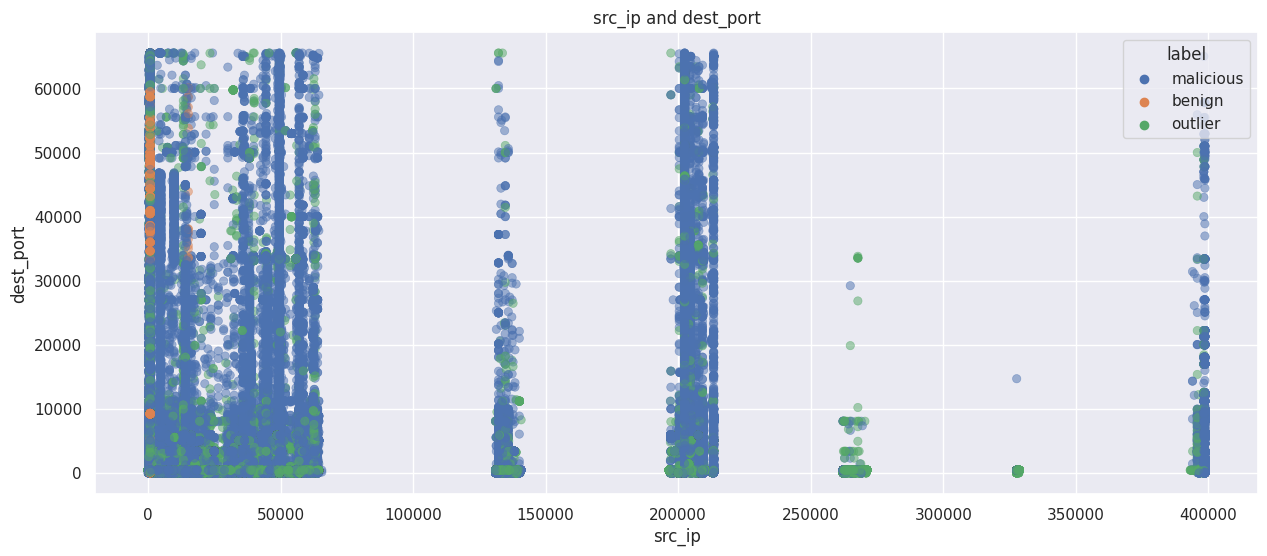

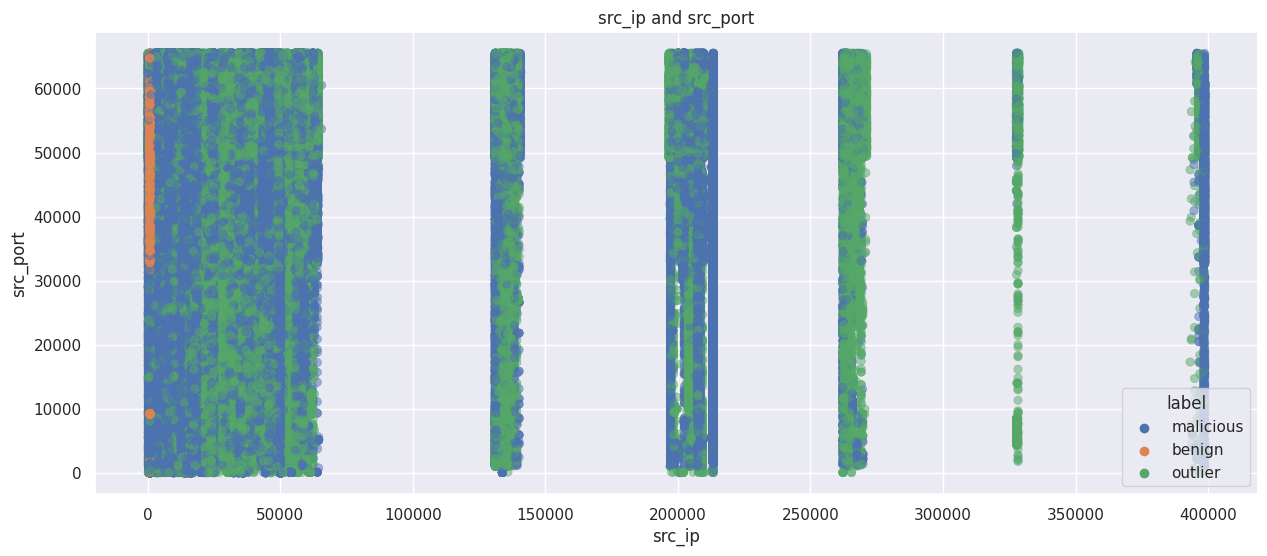

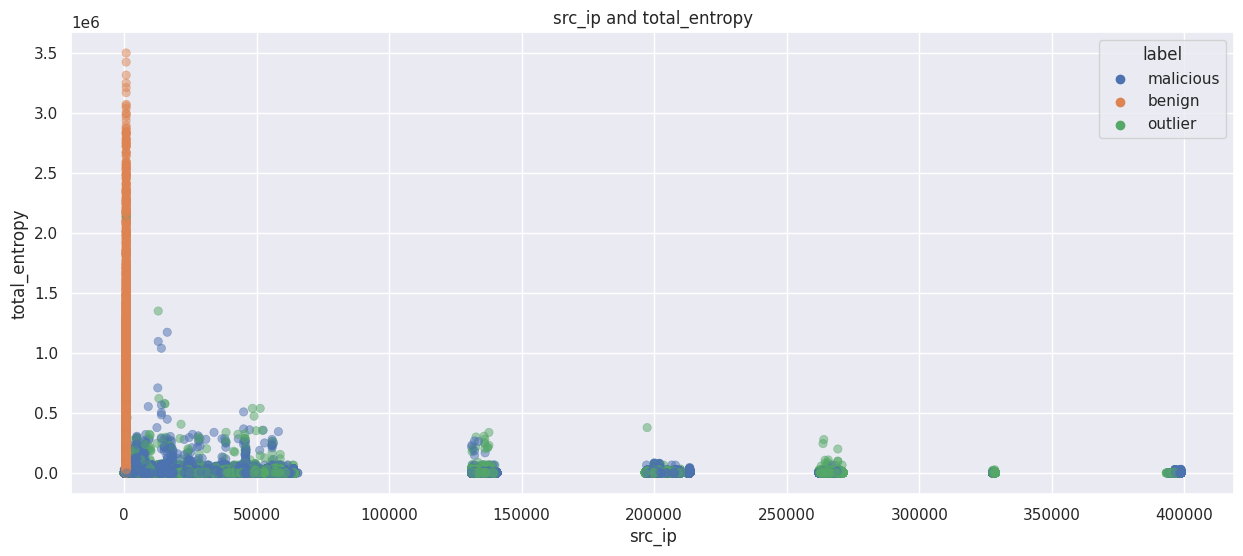

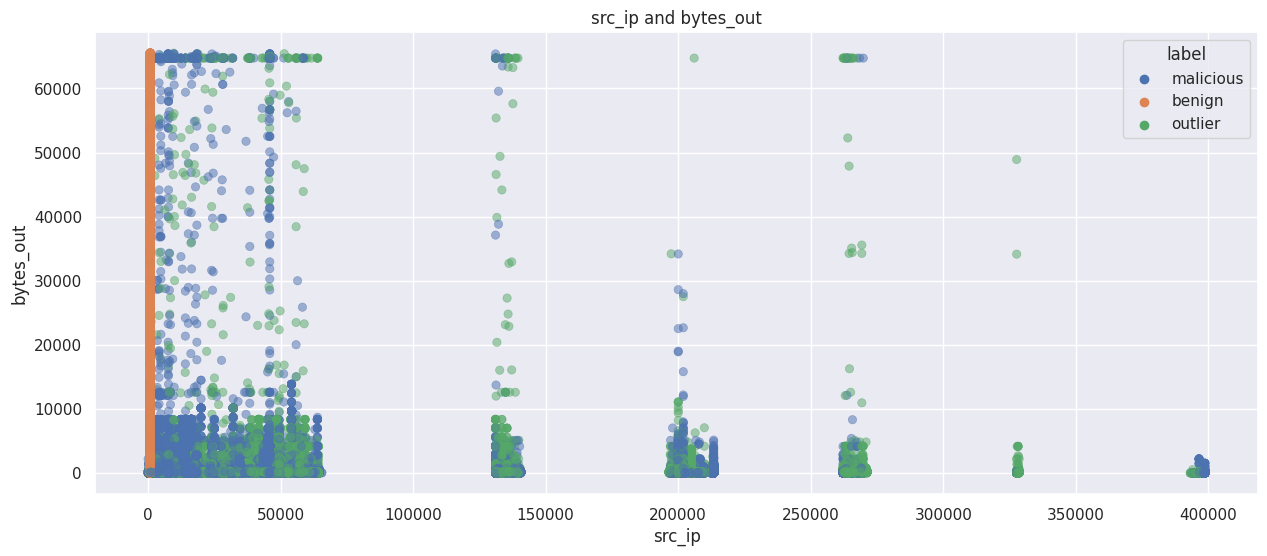

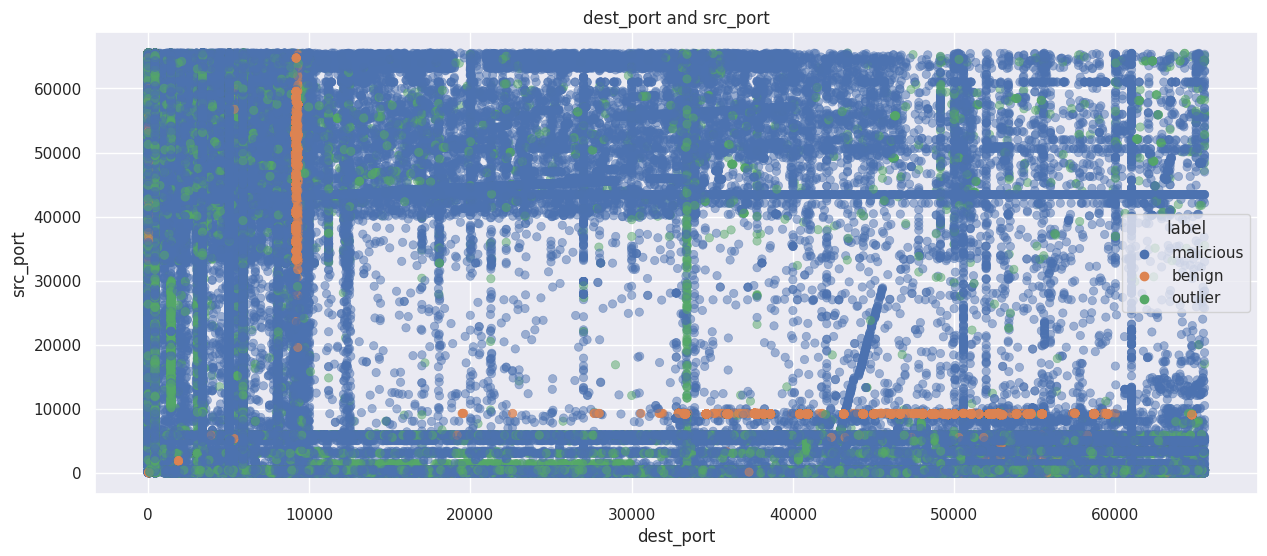

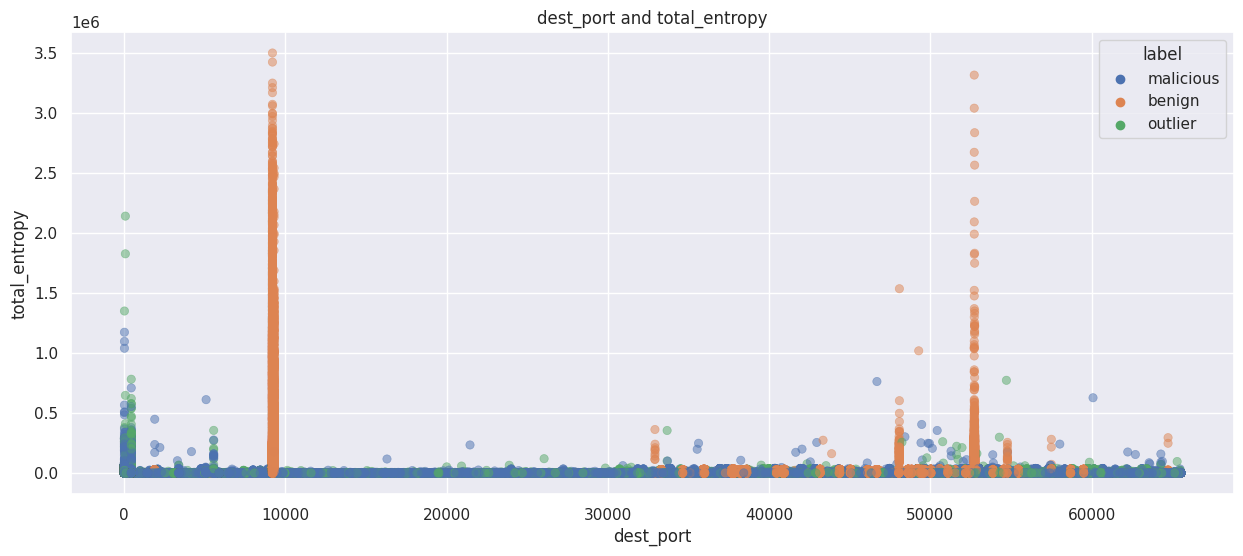

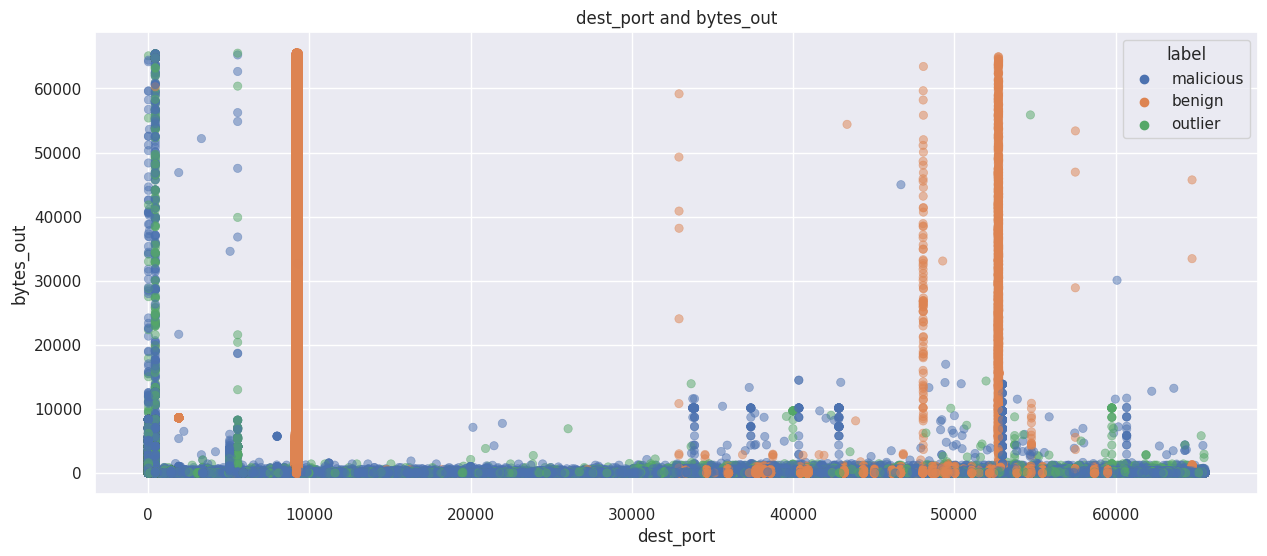

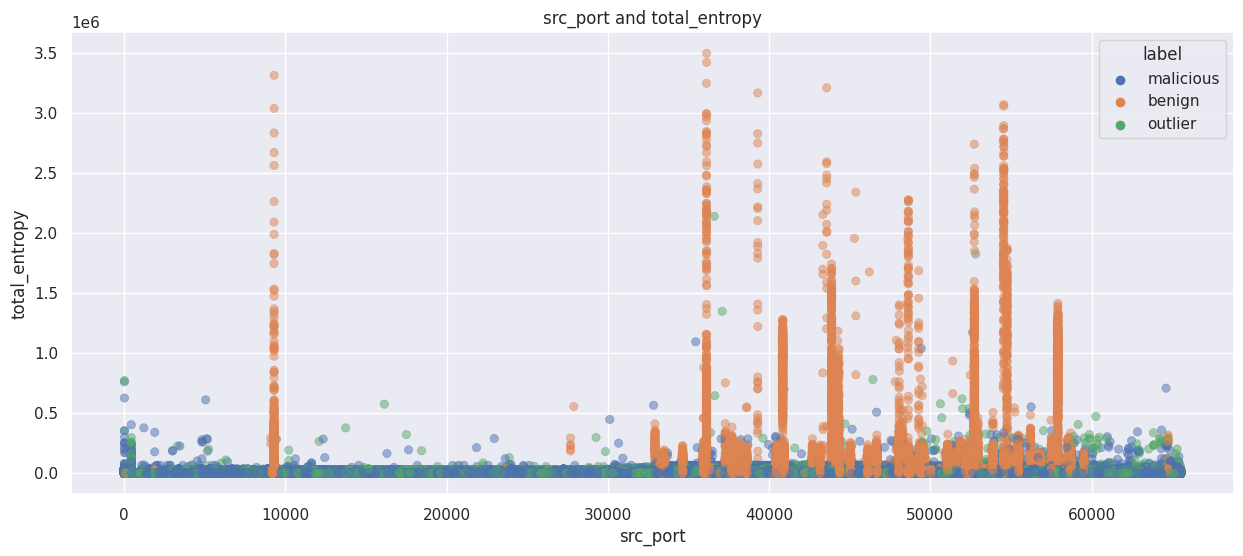

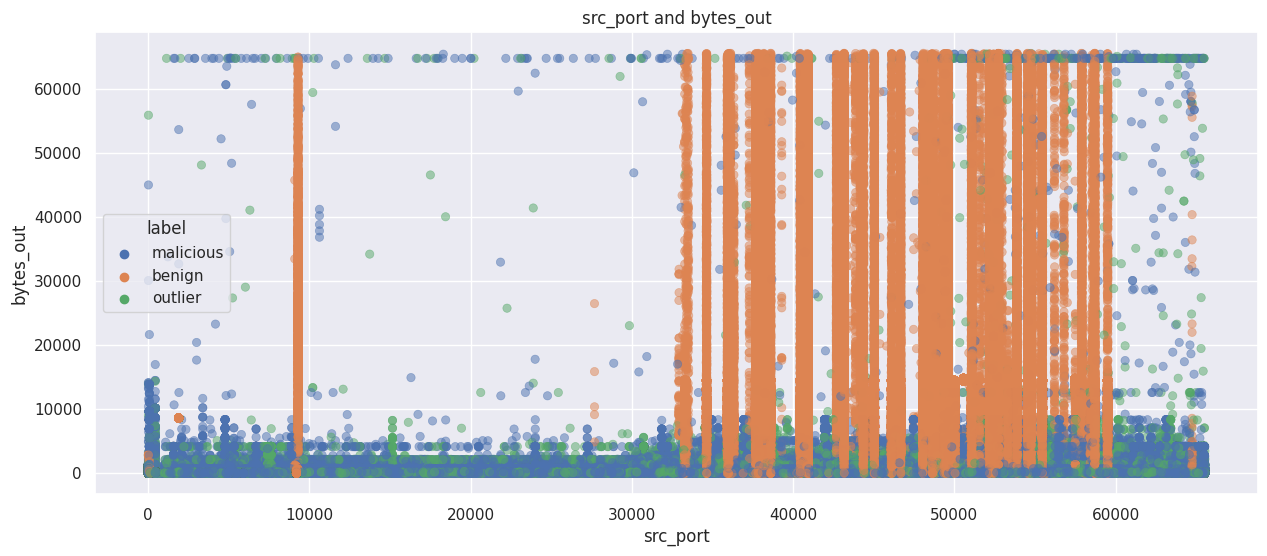

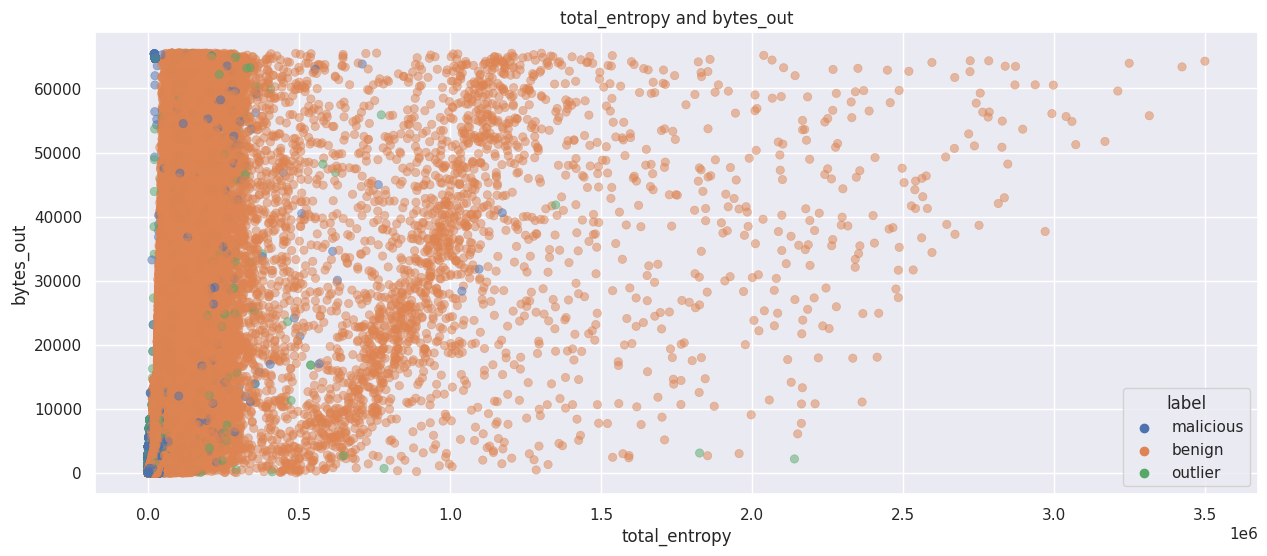

In [13]:
from itertools import combinations

for i, j in combinations(numerical, 2):
    plt.figure(figsize=(15, 6))
    sns.scatterplot(data=sample_df, x=i, y=j, hue="label", alpha=0.5, edgecolor=None)
    plt.title(f"{i} and {j}")
    plt.show()

# Pre-Processing
---

### Removing 5% outliers

In [14]:
print('Lenght of data before removing outliers:', len(df))
for i in df.drop('label', axis=1).columns:
    Q1 = df[i].quantile(0.05)
    Q3 = df[i].quantile(0.95)
    IQR = Q3 - Q1
    df = df[(df[i] >= Q1 - 1.5*IQR) & (df[i] <= Q3 + 1.5*IQR)]
    
print('Length of data after removing outliers:', len(df))

Lenght of data before removing outliers: 25802604
Length of data after removing outliers: 22773727


### Rescaling Data

In [15]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler, Normalizer

"""scaler = StandardScaler()
df[df.drop('label', axis=1).columns] = scaler.fit_transform(df.drop('label', axis=1))"""

scaler = MinMaxScaler()
df[df.drop('label', axis=1).columns] = scaler.fit_transform(df.drop('label', axis=1))

"""scaler = MaxAbsScaler()
df[df.drop('label', axis=1).columns] = scaler.fit_transform(df.drop('label', axis=1))"""

"""scaler = Normalizer()
df[df.drop('label', axis=1).columns] = scaler.fit_transform(df.drop('label', axis=1))"""

"scaler = Normalizer()\ndf[df.drop('label', axis=1).columns] = scaler.fit_transform(df.drop('label', axis=1))"

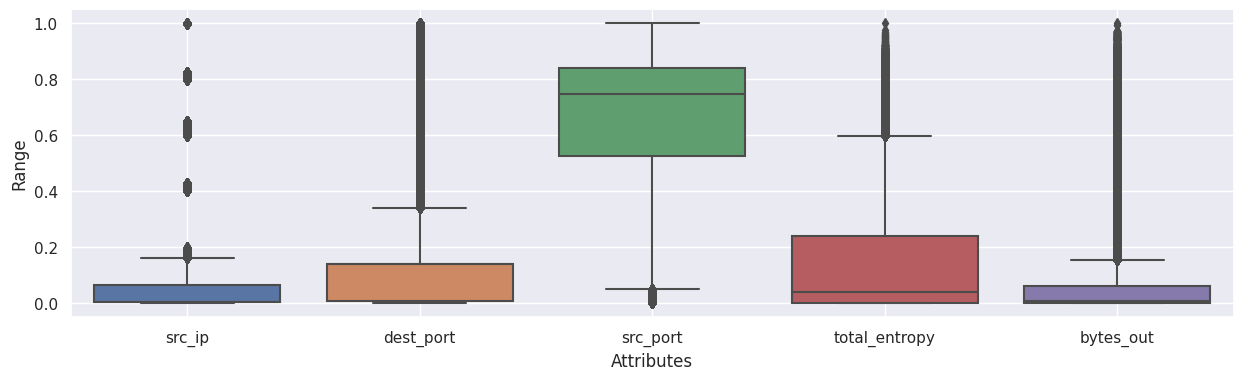

In [16]:
plt.figure(figsize=(15, 4))
sns.boxplot(data=df[numerical])
plt.xlabel("Attributes")
plt.ylabel("Range")
plt.grid(True)
plt.show()

In [17]:
"""from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import hamming_loss

X = df.drop('label', axis=1)
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Initialize the RandomForestClassifier
rf_classifier = RandomForestClassifier()

# Fit the model
rf_classifier.fit(X_train, y_train)

# Predict labels
y_pred = rf_classifier.predict(X_test)

# Ensure y_test is a DataFrame or 2D array
if isinstance(y_test, pd.Series):
    y_test = y_test.to_frame()

# Calculate Hamming Loss
hamming = hamming_loss(y_test, y_pred)
print(f"Hamming Loss: {hamming}")"""

'from sklearn.ensemble import RandomForestClassifier\nfrom sklearn.model_selection import train_test_split\nfrom sklearn.metrics import hamming_loss\n\nX = df.drop(\'label\', axis=1)\ny = df[\'label\']\n\nX_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)\n\n# Initialize the RandomForestClassifier\nrf_classifier = RandomForestClassifier()\n\n# Fit the model\nrf_classifier.fit(X_train, y_train)\n\n# Predict labels\ny_pred = rf_classifier.predict(X_test)\n\n# Ensure y_test is a DataFrame or 2D array\nif isinstance(y_test, pd.Series):\n    y_test = y_test.to_frame()\n\n# Calculate Hamming Loss\nhamming = hamming_loss(y_test, y_pred)\nprint(f"Hamming Loss: {hamming}")'

In [18]:
#comp = pd.DataFrame(columns=['Hamming Loss'])

In [19]:
#comp.loc['MinMax 5% outliers'] = hamming
#comp

# Model Training
---

In [20]:
from sklearn.model_selection import train_test_split

X = df.drop('label', axis=1)
y = df['label']

### Encoding target labels

In [21]:
y = y.replace({'benign':0, 'outlier':2, 'malicious':1}).astype(int)

### Splitting data into training, validation and test sets

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

### Defining the model

In [23]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

def build_model(input_shape, output_dim, optimizer):
    model = Sequential()
    model.add(Dense(2048, activation='relu', input_shape=input_shape))
    model.add(Dense(1024, activation='relu'))
    model.add(Dense(512, activation='relu'))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(8, activation='relu'))
    model.add(Dense(output_dim, activation='softmax'))
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

optimizer = Adam(learning_rate=0.001)
input_shape = (18,)
output_dim = 3
model = build_model(input_shape, output_dim, optimizer)

model.summary()

2024-07-10 15:57:52.201391: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-10 15:57:52.201533: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-10 15:57:52.321668: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 2048)           │        38,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1024)           │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 3)              │            27 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,837,139 (10.82 MB)

 Trainable params: 2,837,139 (10.82 MB)

 Non-trainable params: 0 (0.00 B)

### Setting Early Stopping and Automatic Learning Rate reduction

In [24]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='loss', patience=6, min_delta=0.0001, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=3, min_lr=0.0001)

In [25]:
history = model.fit(
                    X_train, y_train,
                    validation_data=(X_val, y_val),
                    batch_size=1024,
                    epochs=300,
                    callbacks=[early_stopping, reduce_lr],
                    verbose=0)

I0000 00:00:1720627093.781880      71 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1720627093.798918      71 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720627184.801638      71 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


In [26]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def performance_graph(history):
    history_df = pd.DataFrame(history.history)
    fig, axs = plt.subplots(1, 2, figsize=(15, 4))
    history_df.loc[2:, ['loss', 'val_loss']].plot(ax=axs[0])
    history_df.loc[2:, ['accuracy', 'val_accuracy']].plot(ax=axs[1])
    
    print(("Best Validation Loss: {:0.4f}" +\
          "\nBest Validation accuracy: {:0.4f}")\
          .format(history_df['val_loss'].min(), 
                  history_df['val_accuracy'].max()))

Best Validation Loss: 0.1281
Best Validation accuracy: 0.9463


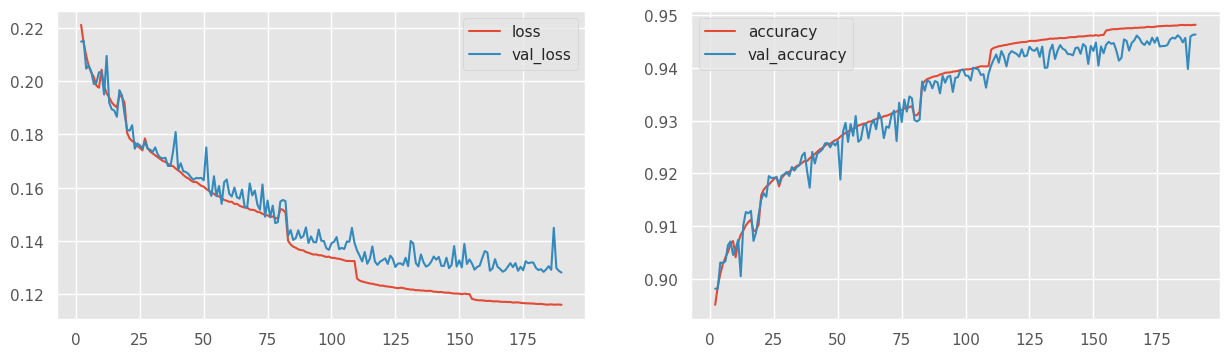

In [27]:
performance_graph(history)

# Evaluation
---

In [28]:
from sklearn.metrics import classification_report, confusion_matrix

def performance_metrics(model, X_test, y_test):
    
    preds = model.predict(X_test)
  
    preds_labels = preds.argmax(axis=1)
    target_names = ['benign', 'malicious', 'outlier']
    
    print(classification_report(y_test, preds_labels, target_names=target_names), '\n')

    cf_matrix = confusion_matrix(y_test, preds_labels, normalize='all')
    fig = px.imshow(pd.DataFrame(cf_matrix, columns=target_names, index=target_names), 
          template='ggplot2', title='Confusion Matrix', aspect='auto', text_auto=True, zmin=0,
          zmax=1, labels={'0':target_names[0],'1':target_names[1]})
    fig.show()

In [29]:
performance_metrics(model, X_test, y_test)

142336/142336 ━━━━━━━━━━━━━━━━━━━━ 188s 1ms/step
              precision    recall  f1-score   support

      benign       1.00      1.00      1.00   2284698
   malicious       0.90      0.94      0.92   1554746
     outlier       0.86      0.79      0.82    715302

    accuracy                           0.95   4554746
   macro avg       0.92      0.91      0.91   4554746
weighted avg       0.95      0.95      0.95   4554746
 



### Predicting on randomly picked data

In [30]:
import numpy as np

sample = X_test.sample(n=10)
preds = model.predict(sample)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 396ms/step


In [31]:
result = pd.DataFrame(index=range(10), columns=['True', 'Prediction', 'Confidence'])
target_names = ['benign', 'malicious', 'outlier'] 

In [32]:
for i in range(len(preds)):
    result['True'].iloc[i] = target_names[y_test[sample.index].values[i]]
    result['Prediction'].iloc[i] = target_names[np.argmax(preds[i], axis=0)]
    result['Confidence'].iloc[i] = preds[i].max()

In [33]:
result

,True,Prediction,Confidence
0,benign,malicious,0.999247
1,outlier,malicious,0.999989
2,benign,benign,1.0
3,malicious,benign,1.0
4,malicious,benign,1.0
5,benign,malicious,1.0
6,benign,malicious,0.823164
7,malicious,malicious,0.924154
8,outlier,benign,1.0
9,benign,outlier,0.999997
